In [1]:
import pandas as pd
import numpy as np

In [2]:
family_data = pd.read_csv('./data/family_data.csv').set_index('family_id')
family_data.sample(3)

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
3347,58,2,26,1,31,10,22,55,80,44,3
1597,1,50,97,96,32,9,4,47,2,26,8
616,44,60,19,24,96,94,26,10,1,5,4


In [3]:
family_data.describe()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000
mean,40.715000,41.601000,41.194200,41.595000,41.950600,42.63520,41.965000,42.739600,42.33900,42.608200,4.20060
std,29.054208,29.518375,28.821878,29.094602,29.045049,28.98729,28.711089,28.959156,28.69832,28.116088,1.53272
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,2.00000
25%,16.000000,16.000000,17.000000,17.000000,17.000000,18.00000,17.000000,18.000000,17.00000,19.000000,3.00000
50%,38.000000,38.000000,38.000000,39.000000,39.000000,40.00000,39.000000,39.000000,39.00000,39.000000,4.00000
75%,62.000000,66.000000,63.000000,66.000000,66.000000,66.00000,66.000000,67.000000,66.00000,66.000000,5.00000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,8.00000


### 任务说明
每个家庭有10个选择choice0-9，每个家庭必须并且只安排一次参观  
家庭数量 5000，每天访问的人数需要在125-300人  
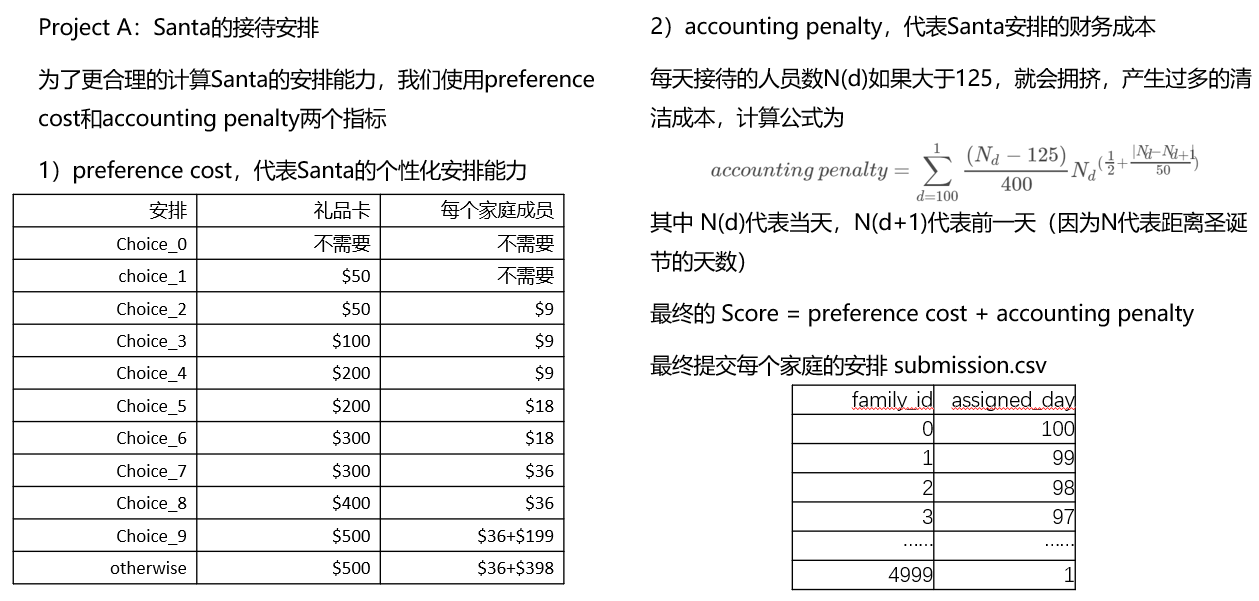

### 步骤
1. 生成每个家庭在每一天产生的p_cost
2. 计算每一天所有可能的财务成本
3. 构建模型

In [4]:
def ChoiceCost(choice, n_people):
    if choice == 0:
        return 0
    if choice == 1:
        return 50
    if choice == 2:
        return 50 + 9 * n_people
    if choice == 3:
        return 100 + 9 * n_people
    if choice == 4:
        return 200 + 9 * n_people
    if choice == 5:
        return 200 + 18 * n_people
    if choice == 6:
        return 300 + 18 * n_people
    if choice == 7:
        return 300 + 36 * n_people
    if choice == 8:
        return 400 + 36 * n_people
    if choice == 9:
        return 500 + (36 + 199) * n_people
    return 500 + (36 + 398) * n_people

In [5]:
# 计算每个家庭在每一天产生的p_cost
n_family, n_days = 5000, 100
p_cost = np.zeros((n_family, n_days))
for i in range(n_family):
    n_people = family_data.iloc[i, -1]
    p_cost[i] = 500 + n_people * (36 + 398)
    for choice in range(10):
        day = family_data.iloc[i, choice]
        p_cost[i, day-1] = ChoiceCost(choice, n_people)
p_cost

array([[2236., 2236., 2236., ..., 2236., 2236., 2236.],
       [2236., 2236., 2236., ..., 2236., 2236., 2236.],
       [1802., 1802., 1802., ..., 1802., 1802.,    0.],
       ...,
       [3104., 3104.,  616., ..., 3104., 3104., 3104.],
       [ 390., 2670., 2670., ..., 2670., 2670., 2670.],
       [2236., 2236., 2236., ..., 2236., 2236., 2236.]])

In [6]:
# 计算
MIN_OCCUPANCY, MAX_OCCUPANCY = 125, 300
a_cost = np.zeros((MAX_OCCUPANCY+1, MAX_OCCUPANCY+1))
for n_d in range(125, 301):
    for n_d_1 in range(125, 301):
        a_cost[n_d, n_d_1] = (n_d - 125) / 400 * n_d ** (0.5 + abs(n_d - n_d_1) / 50)
a_cost

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 7.46610759, 8.36716954,
        9.37697794],
       [0.        , 0.        , 0.        , ..., 8.4302077 , 7.52185316,
        8.4302077 ],
       [0.        , 0.        , 0.        , ..., 9.51970597, 8.49339085,
        7.57772228]])

### 线性规划求解

In [7]:
from ortools.linear_solver import pywraplp

In [8]:
size_family = family_data['n_people'].values
size_family

array([4, 4, 3, ..., 6, 5, 4])

In [9]:
desired = family_data.iloc[:, :-1].values - 1
desired

array([[51, 37, 11, ..., 75,  9, 27],
       [25,  3, 81, ...,  5, 65, 60],
       [99, 53, 24, ..., 88, 79, 32],
       ...,
       [31, 65, 53, ..., 80,  2,  6],
       [66, 91,  3, ..., 11, 25, 69],
       [12, 10, 24, ..., 38, 17, 46]])

In [112]:
%%time
diff_threshold = 35
def solveSantaLP():
    solver = pywraplp.Solver('SantaLP', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    # 决策变量
    candidates = [[] for x in range(n_days)]
    x = {}
    for i in range(n_family):
        for j in desired[i]:
            candidates[j].append(i)
            x[i, j] = solver.BoolVar(f'x[{i}, {j}]')
    # 约束条件
    # 每天的人数上下限
    daily_occupancy = []
    for j in range(n_days):
        daily_occupancy.append(solver.Sum([x[i, j] * size_family[i] for i in candidates[j]]))
    for j in range(n_days):
        solver.Add(daily_occupancy[j] >= MIN_OCCUPANCY)
        solver.Add(daily_occupancy[j] <= MAX_OCCUPANCY)
    # 每个家庭参加一次
    family_presence = []
    for i in range(n_family):
        family_presence.append(solver.Sum([x[i, j] for j in desired[i]]))
        solver.Add(family_presence[i] == 1)
    # 人工约束条件
    for j in range(n_days - 1):
        solver.Add(daily_occupancy[j] - daily_occupancy[j+1] <= diff_threshold)
        solver.Add(daily_occupancy[j+1] - daily_occupancy[j] <= diff_threshold)
    # 目标函数
    obj_pcost = solver.Sum([p_cost[i, j] * x[i, j] for i in range(n_family) for j in desired[i]])
#     obj_acost = solver.Sum([a_cost[daily_occupancy[j], daily_occupancy[j]] for j in range(n_days-1)])
#     solver.Minimize(obj_pcost + obj_acost)
    solver.Minimize(obj_pcost)
    # 求解
    result = solver.Solve()
    print(result)
    print(f'Preference Cost = {solver.Objective().Value()}')
    df_x = pd.DataFrame([[i, j, x[i, j].solution_value()] for i in range(n_family) 
                         for j in desired[i]], columns=['family', 'day', 'result'])
    return df_x
df_x = solveSantaLP()
df_x

0
Preference Cost = 68021.53968253967
CPU times: user 15.3 s, sys: 56.5 ms, total: 15.4 s
Wall time: 15.3 s


,family,day,result
0,0,51,1.0
1,0,37,0.0
2,0,11,0.0
3,0,81,0.0
4,0,32,0.0
...,...,...,...
49995,4999,39,0.0
49996,4999,95,0.0
49997,4999,38,0.0
49998,4999,17,0.0


In [113]:
threshold = 0.999
assigned_df = df_x[df_x['result'] > threshold].astype(int)
assigned_df

,family,day,result
0,0,51,1
10,1,25,1
20,2,99,0
30,3,1,1
40,4,52,1
...,...,...,...
49950,4995,15,1
49960,4996,87,1
49970,4997,31,1
49981,4998,91,1


In [114]:
unassigned_df = df_x[(df_x['result'] <= threshold) & (df_x['result'] > 1 - threshold)]
unassigned_df

,family,day,result
670,67,0,0.400000
673,67,20,0.600000
970,97,95,0.833333
972,97,47,0.166667
2330,233,86,0.666667
...,...,...,...
47721,4772,45,0.666667
48860,4886,27,0.250000
48861,4886,98,0.750000
49500,4950,37,0.666667


In [115]:
unassigned_family = list(unassigned_df['family'].drop_duplicates())
print(unassigned_family[:5])
print(len(unassigned_family))

[67, 97, 233, 344, 500]
63


### 整数规划求解

In [116]:
tmp_daily_occupancy = np.zeros(n_days)
for _, tmp in assigned_df.iterrows():
    i, j, _ = tmp
    tmp_daily_occupancy[j] += size_family[i]
tmp_daily_occupancy  # 已安排的家庭在每天的人数

array([281., 265., 299., 298., 282., 244., 208., 224., 257., 292., 299.,
       290., 265., 241., 222., 262., 295., 293., 274., 239., 199., 229.,
       254., 296., 296., 297., 264., 231., 234., 244., 287., 299., 262.,
       226., 193., 166., 192., 227., 271., 245., 204., 174., 191., 230.,
       258., 298., 262., 223., 196., 182., 219., 251., 273., 241., 203.,
       165., 169., 201., 238., 225., 192., 160., 119., 121., 146., 181.,
       197., 164., 131., 124., 125., 127., 162., 197., 160., 127., 125.,
       125., 138., 171., 204., 169., 138., 124., 120., 159., 193., 225.,
       193., 156., 122., 124., 126., 158., 193., 156., 123., 125., 122.,
       124.])

In [118]:
diff_threshold = 40

In [119]:
%%time
def solveSantaMIP():
    solver = pywraplp.Solver('SantaMIP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    # 决策变量
    candidates = [[] for x in range(n_days)]
    x = {}
    for i in unassigned_family:
        for j in desired[i]:
            candidates[j].append(i)
            x[i, j] = solver.BoolVar(f'x[{i}, {j}]')
    # 约束条件
    # 每天的人数上下限
    daily_occupancy = []
    for j in range(n_days):
        daily_occupancy.append(tmp_daily_occupancy[j] + 
                               solver.Sum([x[i, j] * size_family[i] for i in candidates[j]]))
    for j in range(n_days):
        solver.Add(daily_occupancy[j] >= MIN_OCCUPANCY)
        solver.Add(daily_occupancy[j] <= MAX_OCCUPANCY)
    # 每个家庭参加一次
    family_presence = []
    for i in unassigned_family:
#         family_presence.append(solver.Sum([x[i, j] for j in desired[i]]))
        solver.Add(solver.Sum([x[i, j] for j in desired[i]]) == 1)
    # 人工约束条件
    for j in range(n_days - 1):
        solver.Add(daily_occupancy[j] - daily_occupancy[j+1] <= diff_threshold)
        solver.Add(daily_occupancy[j+1] - daily_occupancy[j] <= diff_threshold)
    # 目标函数
    obj_pcost = solver.Sum([p_cost[i, j] * x[i, j] for i in unassigned_family for j in desired[i]])
#     obj_acost = solver.Sum([a_cost[daily_occupancy[j], daily_occupancy[j]] for j in range(n_days-1)])
#     solver.Minimize(obj_pcost + obj_acost)
    solver.Minimize(obj_pcost)
    # 求解
    result = solver.Solve()
    print(result)
    print(f'Preference Cost = {solver.Objective().Value()}')
    df_x = pd.DataFrame([[i, j, x[i, j].solution_value()] for i in unassigned_family 
                         for j in desired[i]], columns=['family', 'day', 'result'])
    return df_x
df_y = solveSantaMIP()
df_y

0
Preference Cost = 2453.0
CPU times: user 412 ms, sys: 16.9 ms, total: 429 ms
Wall time: 426 ms


,family,day,result
0,67,0,1.0
1,67,93,0.0
2,67,44,0.0
3,67,20,0.0
4,67,9,0.0
...,...,...,...
625,4950,47,0.0
626,4950,3,0.0
627,4950,25,0.0
628,4950,0,0.0


### 合并结果

In [120]:
df_res = assigned_df.append(df_y[df_y['result'] > 0]).sort_values('family').reset_index(drop=True)
df_res = df_res.astype(int)
df_res

,family,day,result
0,0,51,1
1,1,25,1
2,2,99,0
3,3,1,1
4,4,52,1
...,...,...,...
4995,4995,15,1
4996,4996,87,1
4997,4997,31,1
4998,4998,91,1


In [134]:
daily_occupancy = np.zeros(n_days)
for _, tmp in df_res.iterrows():
    i, j, _ = tmp
    daily_occupancy[j] += size_family[i]
daily_occupancy = daily_occupancy.astype('int')
daily_occupancy

array([300, 265, 299, 298, 282, 244, 208, 234, 257, 297, 299, 298, 265,
       241, 222, 262, 299, 299, 278, 239, 199, 229, 259, 299, 300, 297,
       269, 231, 234, 251, 287, 299, 270, 231, 193, 169, 206, 243, 280,
       249, 209, 174, 191, 230, 268, 298, 262, 223, 196, 182, 219, 259,
       281, 241, 203, 176, 169, 206, 241, 232, 198, 160, 129, 125, 146,
       181, 203, 164, 131, 127, 125, 127, 167, 197, 164, 127, 125, 125,
       138, 175, 210, 177, 138, 126, 128, 159, 193, 231, 193, 156, 130,
       127, 126, 164, 197, 165, 128, 125, 126, 129])

In [122]:
preference_cost = sum([p_cost[i, j] for _, (i, j, _) in df_res.iterrows()])
preference_cost

67867.0

In [123]:
accounting_cost = 0
for j in range(n_days - 1):
    accounting_cost += a_cost[daily_occupancy[j], daily_occupancy[j+1]]
accounting_cost

10941.992479775154

In [124]:
score = preference_cost + accounting_cost
score

78808.99247977516